In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from SubjectiveLogic import Hyperopinion, HyperopinionInterface
from SubjectiveLogic import Hyperopinion as W
from SubjectiveLogic.BeliefFusion import cumulative_fusion, averaging_fusion, weighted_fusion
from SubjectiveLogic.Trust import trust_discount_2e
from Model import *
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Callable
from matplotlib.ticker import MaxNLocator
import pandas as pd

In [3]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [4]:
NUM_AGENTS = 10
NUM_STEPS = 30

In [5]:
def simulate(initial_configuration: BeliefArray, influence_graph: InfluenceGraph, akv_num_steps=NUM_STEPS, sl_model=NUM_STEPS):
    akv_model = AKVModel(initial_configuration, influence_graph)
    sl_model_cumulative = akv_to_sl(akv_model)
    sl_model_average = akv_to_sl(akv_model)
    sl_model_weighted = akv_to_sl(akv_model)

    akv_model.simulate(akv_num_steps)
    sl_model_cumulative.simulate(sl_model, cumulative_fusion)
    sl_model_average.simulate(sl_model, averaging_fusion)
    sl_model_weighted.simulate(sl_model, weighted_fusion)

    return akv_model, sl_model_cumulative, sl_model_average, sl_model_weighted



[0.31, 0.69]
[0.46, 0.46]


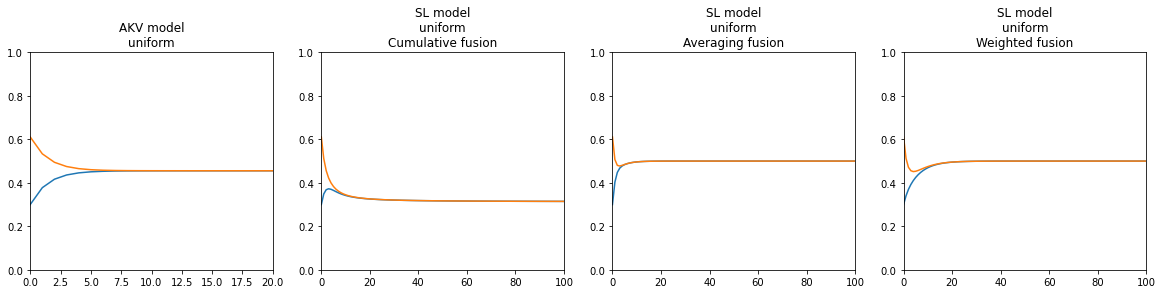

In [73]:
AKV_NUM_STEPS = 20
SL_STEPS = 100
NUM_AGENTS = 2

akv_model = AKVModel([0.3, 0.611], [[1, 0.5], [0.5, 1]])
sl_model_cumulative = akv_to_sl(akv_model)
sl_model_average = akv_to_sl(akv_model)
sl_model_weighted = akv_to_sl(akv_model)

akv_model.simulate(AKV_NUM_STEPS)
sl_model_cumulative.simulate(SL_STEPS, cumulative_fusion)
sl_model_average.simulate(SL_STEPS, averaging_fusion)
sl_model_weighted.simulate(SL_STEPS, weighted_fusion)

fig, ax = plt.subplots(1, 4)
fig.set(figwidth=20)
for i in range(NUM_AGENTS):
    print()
    ax[0].plot(list(range(AKV_NUM_STEPS + 1)), [akv_model.states[j][i] for j in range(AKV_NUM_STEPS + 1)])
    ax[1].plot(list(range(SL_STEPS + 1)), [sl_model_cumulative.states[j][i].P[0] for j in range(SL_STEPS + 1)])
    ax[2].plot(list(range(SL_STEPS + 1)), [sl_model_average.states[j][i].P[0] for j in range(SL_STEPS + 1)])
    ax[3].plot(list(range(SL_STEPS + 1)), [sl_model_weighted.states[j][i].P[0] for j in range(SL_STEPS + 1)])

ax[0].set_title("AKV model\nuniform")
ax[1].set_title("SL model\nuniform\nCumulative fusion")
ax[2].set_title("SL model\nuniform\nAveraging fusion")
ax[3].set_title("SL model\nuniform\nWeighted fusion")
for i in range(4):
    ax[i].set_ylim([0, 1])
    ax[i].set_xlim([0, AKV_NUM_STEPS if i == 0 else SL_STEPS])

# print(sl_model_cumulative.belief_array())
print([round(i, 2) for i in sl_model_cumulative.states[-1][1].P])
print([round(i, 2) for i in akv_model.states[-1]])

# Are we interpreting wrongly?
# Why is evidence being removed?
# Operational significance

In [7]:
np.arange(0.1, 1, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [71]:
AKV_NUM_STEPS = 20
SL_STEPS = 100
NUM_AGENTS = 2

data = []

for b1 in np.arange(0.1, 1, 0.1):
    for b2 in np.arange(0.1, 1, 0.1):
        akv_model = AKVModel([b1, b2], [[1, 1], [1, 1]])
        sl_model_cumulative = akv_to_sl(akv_model)
        akv_model.simulate(AKV_NUM_STEPS)
        sl_model_cumulative.simulate(SL_STEPS, cumulative_fusion)
        data.append([b1, b2, sl_model_cumulative.states[-1][1].P[0], akv_model.states[-1][0]])

df = pd.DataFrame(data, columns=["P(A[0], X)", "P(B[0], X)", "P(B[inf], X)", "AKV.Bel(inf, A)"])
df['between A and B'] = np.where((df["P(A[0], X)"] < df["P(B[inf], X)"]) & (df["P(B[inf], X)"] < df["P(B[0], X)"]), "Yes", "No")
df['test'] = 1 - df["P(B[0], X)"]


In [72]:
# df.round(3)[(df["P(A[0], X)"] < 0.5) & (df["P(B[0], X)"] > 0.5) & (df["P(A[0], X)"] != (1 - df["P(B[0], X)"]))]
df[(df["P(A[0], X)"] < 0.5) & (df["P(B[0], X)"] > 0.5) & ~(np.isclose(df["P(A[0], X)"], 1 - df["P(B[0], X)"]))].round(3)

,"P(A[0], X)","P(B[0], X)","P(B[inf], X)","AKV.Bel(inf, A)",between A and B,test
5,0.1,0.6,0.059,0.35,No,0.4
6,0.1,0.7,0.143,0.40,Yes,0.3
7,0.1,0.8,0.273,0.45,Yes,0.2
14,0.2,0.6,0.143,0.40,No,0.4
15,0.2,0.7,0.308,0.45,Yes,0.3
17,0.2,0.9,0.727,0.55,Yes,0.1
23,0.3,0.6,0.273,0.45,No,0.4
25,0.3,0.8,0.692,0.55,Yes,0.2
26,0.3,0.9,0.857,0.60,Yes,0.1
33,0.4,0.7,0.727,0.55,No,0.3


In [61]:
df["P(A[0], X)"][0] == 1 - df["P(B[0], X)"][8]

False

In [62]:
df["P(A[0], X)"][0]

0.1

In [63]:
1 - df["P(B[0], X)"][8]

0.09999999999999998

In [56]:
(df["P(A[0], X)"]) == 1- (df["P(B[0], X)"])

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32     True
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40     True
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48     True
49    False
50    False
51    False
52    False
53    False
54    False
55    False
56    False
57    False
58    False
59    False
60    False
61    False
62    False
63    False
64     True
65    False
66    False
67    False
68    False
69    False
70    False
71    False
72     True
73    False
74    False
75    False
76    False
77    False
78    False
79    False
80    False
dtype: bool

In [10]:
sl_model_weighted.states[0]


[Hyperopinion(2, [0.  0.8], [0.5 0.5]), Hyperopinion(2, [0.  0.8], [0.5 0.5])]

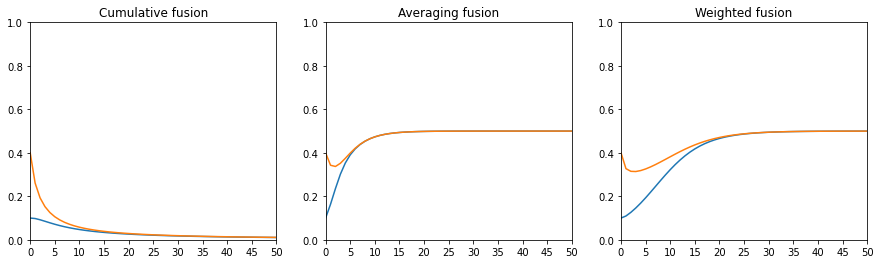

In [11]:
AKV_NUM_STEPS = 10
SL_STEPS = 50
NUM_AGENTS = 2

akv_model = AKVModel([0.1, 0.4], [[1, 0.5], [0.5, 1]])
sl_model_cumulative = akv_to_sl(akv_model)
sl_model_average = akv_to_sl(akv_model)
sl_model_weighted = akv_to_sl(akv_model)

akv_model.simulate(AKV_NUM_STEPS)
sl_model_cumulative.simulate(SL_STEPS, cumulative_fusion)
sl_model_average.simulate(SL_STEPS, averaging_fusion)
sl_model_weighted.simulate(SL_STEPS, weighted_fusion)

fig, ax = plt.subplots(1, 3)
fig.set(figwidth=15)
for i in range(NUM_AGENTS):
    print()
    ax[0].plot(list(range(SL_STEPS + 1)), [sl_model_cumulative.states[j][i].P[0] for j in range(SL_STEPS + 1)])
    ax[1].plot(list(range(SL_STEPS + 1)), [sl_model_average.states[j][i].P[0] for j in range(SL_STEPS + 1)])
    ax[2].plot(list(range(SL_STEPS + 1)), [sl_model_weighted.states[j][i].P[0] for j in range(SL_STEPS + 1)])

ax[0].set_title(r"Cumulative fusion")
ax[1].set_title(r"Averaging fusion")
ax[2].set_title(r"Weighted fusion")
for i in range(3):
    ax[i].set_ylim([0, 1])
    ax[i].set_xlim([0, SL_STEPS])
    ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))

In [12]:
sl_model_cumulative.trust_graph

[[None, Hyperopinion(2, [0.5 0.5], [0.5 0.5])],
 [Hyperopinion(2, [0.5 0.5], [0.5 0.5]), None]]

In [13]:
sl_model_weighted.states

[[Hyperopinion(2, [0.  0.8], [0.5 0.5]),
  Hyperopinion(2, [0.  0.2], [0.5 0.5])],
 [Hyperopinion(2, [0.       0.781081], [0.5 0.5]),
  Hyperopinion(2, [0.       0.345455], [0.5 0.5])],
 [Hyperopinion(2, [0.       0.747449], [0.5 0.5]),
  Hyperopinion(2, [0.       0.370178], [0.5 0.5])],
 [Hyperopinion(2, [0.       0.707368], [0.5 0.5]),
  Hyperopinion(2, [0.       0.371965], [0.5 0.5])],
 [Hyperopinion(2, [0.       0.662343], [0.5 0.5]),
  Hyperopinion(2, [0.       0.363186], [0.5 0.5])],
 [Hyperopinion(2, [0.       0.613489], [0.5 0.5]),
  Hyperopinion(2, [0.       0.348308], [0.5 0.5])],
 [Hyperopinion(2, [0.       0.561965], [0.5 0.5]),
  Hyperopinion(2, [0.       0.329483], [0.5 0.5])],
 [Hyperopinion(2, [0.       0.509034], [0.5 0.5]),
  Hyperopinion(2, [0.       0.307998], [0.5 0.5])],
 [Hyperopinion(2, [0.      0.45601], [0.5 0.5]),
  Hyperopinion(2, [0.       0.284782], [0.5 0.5])],
 [Hyperopinion(2, [0.       0.404162], [0.5 0.5]),
  Hyperopinion(2, [0.       0.260603], [0.5 

In [14]:
akv_model = AKVModel([0.4, 0.2], [[1, 0.5], [0.5, 1]])
akv_model.simulate(1)
akv_model.states

[[0.4, 0.2], array([0.35, 0.25])]

In [15]:
0.325+0.275

0.6000000000000001